# Effect of Group Norms and Social Identities on Construction Workers' Safety Behavior


## Goal
This project aims to investigate the effect of group norms and social identities on construction worker's safety behavior by developing ABM which represents of social influence process regarding construction worker's safety behavior.

## Justification
Although, previous variable based research efforts have some light on the effect of group norms on individual's behavior, the mechanisms underlie the link between social influnece and invidual's behavior are still unclear. In addition, variable-based approach may not be sufficient to consider the characteristics inherent in construction (e.g., complex organizational hierarchy) and thus a more comprehensive research methodology is required. To address these issues, we will develop agent based model which has strength in generating complex social phenomena as emerging from individuals’interactions

## Process and Mechanism of Interest
We are primarily interested in how different range of group norms and social identies affect the construction workers' safety behavior. Additionally, we are also interested in the effect of strict safety rules on the construction workers' safety behavior.

## Outline
* Vary salience of crew based identity
* Vary salience of project based identity
* Vary strictictness of safety rules
* Vary frequency of safety inspection 
* Observe how construction wokrers' safety behaviors are changed.


##I. Space
In this model, the space will be a two-dimensional (2D) rectangular grid. Each grid will be occupied by only one people (workers or managers). Edges of the grid will wrap around. In addition, there are some clusters in the space which means workspace for a specific crew. In addition, the cluster of each crew can be overlapped with other cluster for other crew. 

## II. Agent
###   A. Worker
The main concern in this model is effect of group norms and social identities on construction workers' safety behavior. The expanded theory of planned behavior will be used for workers' behavioral rule.

** Properties **

* Safety behavior; individual's level of safety behavior;  0 - 1 (unsafe - safe)
* Intention; Individual's willingness to perform a specific behavior;  0 - 1 (unsafe - safe)
* PBC (Perceived Behavioral Control); Individuals' perception on their ability to perform a specific behavior; 0 - 1 (easy - difficult)
* Personal Attitude; Individual's evaluation on a specific behavior; 0 - 1 (unsafe - safe)
* Perceived Workgroup Norm; the result of observing behaviors others in their crew.
* Perceived Project Norm ; the result of observing other crew members' behavior and managers' feedback 

* Crew based social identity; Individual's level of social identification with their crew membership ; 0 - 1
* Project based social identity; Individual's level of social identification with their project membership; 0 - 1
* Norm compliance : Individual's level of complying to group norms
* Internalization : Individual's level of internalizing the group norms as their own attitude
* Memory capacity : Individual's capacity of memory to remember others' behavior

* Weight for attitude
* Weight for Intention

* Remembered behavior: List of other workers' behaviors and managers' feedback remembered by the worker

For their step function, the workers will perform followings:
  * Observing and remember other workers' behavior and managers' feedback 
  * Perceiving the workgroup norm and project norm
  * Forming behavioral intention based on precived group norms, personal attitude, social identities and PBC.
  * Internalizing the group norms as their own attitude
  * Taking behaviors based on behavioral intention and PBC
  
### B. Manager
The managers will give a feedback to workers based on strictness of safety rule. 

## III. Initial Conditions
### A. Worker
* Workers will be randomly distributed throguthout the certain range of the grid. Crew members are working together at a construction site, and thus cluster (range of the grid) for each crew is requried to reflect this work process. 
* Worker will have their own properties randomly initialized to a value from a uniform distribution.

### B. Manager
Managers will be randomly ditributed throughout the grid by sampling from a uniform discrete distribution with replacement. In the event that an agent (workers or managers) has already been placed at the sampled location, we continue drawing a new nandom position until it is unoccupied.

###IV. Model Parameters
Based on the description above, the model need the following parameters:
* grid_size_for_crew
* overlaps_between_crew_grid
* num_workers: number of workers in one crew
* num_crews: number of crews in the project
* num_managers; it means the frequency of safety inspection by managers in the project
* min_project_identity, max_project_identity; the lower and upper bound of project based identity
* min_crew_identity, max_crew_identity; the lower and upper bound of crew based identity
* weight_attitude
* weight_perceived_norm
* norm_compliance
* internalization
* memory_capa
* strictness_safety_rule

In [288]:
%matplotlib inline

# Standard imports
import copy
import itertools

# Scientific computing imports
import numpy
import matplotlib.pyplot as plt
import networkx
import pandas
import seaborn; seaborn.set()

# Import widget methods
from IPython.html.widgets import *

### Worker Class
Below, I will define workere class, This can be broken up as follows:
* constructor: class constructor, which initializes the worker when the model call Worker().
* perceving norms : Perceiving workgroup norm and project norm based on the result of observation of other worker's beahvior and manager's feedback
* intention forming : Forming behavioral intention based on precived group norms, personal attitude, social identities and PBC.
* behavior taking : Taking behaviors based on behavioral intention and PBC
* internalizing perceived group norm : Internalizing the group norms as their own attitude.    

In [340]:
class Worker (object):
    """ Worker class, which encapsulate the safety behavior of a worker
    """
    def __init__(self, model, worker_id, crew_type, safety_behavior=0.5, intention=0.5, perceived_behavioral_control=0.5, 
                 attitude=0.5, perceived_workgroup_norm = 0.5, perceived_project_norm = 0.5,crew_identity = 0.5, 
                 project_identity=0.5, norm_compliance = 0.25, internalization = 0.1, memory_capa = 30, weight_attitude = 0.8,
                 weight_intention = 0.8):
        """ Constructor for worker class.
            No default
            Note that this class must link to parent Model object
        """
        
        # Set model and link and ID
        self.model = model
        self.worker_id = worker_id
        self.crew_type = crew_type
        
        # Set Worker Parameters
        self.safety_behavior = safety_behavior
        self.intention = intention
        self.perceived_behavioral_control = perceived_behavioral_control
        self.attitude = attitude
        self.perceived_workgroup_norm = perceived_workgroup_norm
        self.perceived_project_norm = perceived_project_norm
        
        self.crew_identity = crew_identity
        self.project_identity = project_identity
        
        self.norm_compliance = norm_compliance
        self.internalization = internalization
        self.memory_capa = memory_capa
        
        self.weight_attitude = weight_attitude
        self.weight_intention = weight_intention
        self.remembered_behavior = []
        self.workgroup_behavior = []
        self.project_behavior = []
        self.my_safety_behavior_history = []

    
    def workgroup_norm_perceiving(self):
        """
        Perceive workgroup norm from average of crew member's behavior
        """
        
        del self.workgroup_behavior[0:len(self.workgroup_behavior)]
        
        for i in range (len(self.remembered_behavior)):
            # Add same crew members' behavior to workgroup behavior list
            if self.remembered_behavior[i][0] == 0: 
                # This condition means that this behavior is from crew member
                self.workgroup_behavior.append(self.remembered_behavior[i][1])

        if len(self.workgroup_behavior) == 0:
            # This condition means there is no observation from other crew members or managers. 
            self.perceived_workgroup_norm = 0
        
        else:
            # Perceived group norm is average of remembered workgroup behaviors 
            self.perceived_workgroup_norm = sum(self.workgroup_behavior)/len(self.workgroup_behavior)
        
        return


    def project_norm_perceiving(self):
        """
        Perceive project norm from average of other crew member's behavior and manager's feedback
        """
        del self.project_behavior[0:len(self.project_behavior)]
        
        for i in range (len(self.remembered_behavior)):
            # Add same crew members' behavior to workgroup behavior list
            if self.remembered_behavior[i][0] != 0: 
                # This condition means that this behavior is from crew member
                self.project_behavior.append(self.remembered_behavior[i][1])

        if len(self.project_behavior) == 0:
            # This condition means there is no observation from other crew members or managers. 
            self.perceived_project_norm = 0
        else:
            # Perceived group norm is average of remembered workgroup behaviors 
            self.perceived_project_norm = sum(self.project_behavior)/len(self.project_behavior)
        
        return 
    
    def intention_forming(self):
        """
        Forming the behavioral intention
        """
        if self.perceived_project_norm == 0:
            # This condition means there is no observation from other crew members or managers
            # In this condition, we do not care about project based identity 
            self.social_influence = self.norm_compliance*self.crew_identity
            
        elif self.perceived_workgroup_norm == 0:
            # This condition means there is no observation from same crew members
            # In this condition, we do not care about crew based identity             
            self.social_influence = self.norm_compliance*self.project_identity
        
        else:
            self.social_influence = self.norm_compliance*(self.crew_identity+self.project_identity)
        
        self.intention=(self.weight_attitude*self.attitude+(1-self.weight_attitude)*self.perceived_behavioral_control)*(1-self.social_influence)+self.norm_compliance*(self.crew_identity*self.perceived_workgroup_norm+self.project_identity*self.perceived_project_norm)   
        
        return        
    
    def behavior_taking(self):
        """
        Decide the level of safety behavior
        """
        self.safety_behavior = self.weight_intention*self.intention+(1-self.weight_intention)*self.perceived_behavioral_control
        self.my_safety_behavior_history.append(self.safety_behavior)

        return 
      
    def attitude_changing(self):
        """
        Intenralizing group norms as their own attitude
        """
        self.attitude = self.attitude+self.internalization*(self.crew_identity*(self.perceived_workgroup_norm-self.attitude) + self.project_identity*(self.perceived_project_norm-self.attitude))/self.memory_capa
        
        return

    def get_position(self):
        """
        Return position, calling through model
        """
        return self.model.get_worker_position(self.worker_id)
    
    def get_neighbors(self):
        """
        Return neighbors, calling through model
        """
        return self.model.get_worker_neighbors(self.worker_id)

### Manager Class
Below, I will define manager class, The manager just give a feedback to construction workers based on strictness of safety rule.
* constructor: class constructor, which initializes the manager when the model call Manager().

In [341]:
class Manager (object):
    """ Manager class, which encapsulate the safety behavior of a worker
    """
    def __init__(self, model, manager_id, safety_behavior=0.2):
        
        """ Constructor for manager class.
            No default
            Note that this class must link to parent Model object
        """
        
        # Set model and link and ID
        self.model = model
        self.manager_id = manager_id
        self.safety_behavior = safety_behavior

###Model Class
Below, we will define our model class. This can be broken up as follows:

* constructor: class constructor, which initializes the worker when the model call Model().
* setup_space: method to create "space"
* setup_worker: method to create "worker"
* setup_manager: method to create our "manager"
* get_neighbors: method to get neighboring agents based on position
* get_worker_neighbors: method to get neighboring agents based on worker ID
* get_worker_position: method to get position based on worker ID
* step_worker_move: method to step through worker moves
* step_manager_move: method to step through manager moves
* step_interact: method to step through agent interaction
* step: main step method to control each time step simulation

In [368]:
class Model (object):
    """
    Model class, which encapsultes the entire behavior of single run in our model.
    """
    def __init__(self,grid_size_for_crew = 5, overlaps_between_crew_grid =1,num_crews = 10,
                num_workers = 10,num_managers = 25, min_project_identity = 0.5, max_project_identity=0.9,
                min_crew_identity = 0.7, max_crew_identity = 1.0, min_attitude = 0.2, max_attitude = 0.5,
                min_perceived_workgroup_norm = 0.4, max_perceived_workgroup_norm = 0.7, 
                min_perceived_project_norm = 0.6, max_perceived_project_norm = 0.8,
                min_perceived_behavioral_control = 0.2,max_perceived_behavioral_control = 0.6, strictness_safety_rule = 0.8,
                weight_attitude = 0.7, weight_intention = 0.85, norm_compliance = 0.45, internalization = 0.015, memory_capa = 50):
        """
        Class constructor
        """
        # Set the model parameters
        self.grid_size_for_crew = grid_size_for_crew
        self.overlaps_between_crew_grid = overlaps_between_crew_grid     
        self.num_crews = num_crews
        self.num_workers = num_workers
        self.num_managers = num_managers
        self.min_project_identity = min_project_identity
        self.max_project_identity = max_project_identity
        self.min_crew_identity = min_crew_identity
        self.max_crew_identity = max_crew_identity
        self.min_attitude = min_attitude
        self.max_attitude = max_attitude
        self.min_perceived_workgroup_norm = min_perceived_workgroup_norm
        self.max_perceived_workgroup_norm = max_perceived_workgroup_norm
        self.min_perceived_project_norm = min_perceived_project_norm
        self.max_perceived_project_norm = max_perceived_project_norm
        self.min_perceived_behavioral_control = min_perceived_behavioral_control
        self.max_perceived_behavioral_control = max_perceived_behavioral_control
        self.strictness_safety_rule = strictness_safety_rule
                
        # Set state variables
        self.t = 0
        self.space = numpy.array((0,0))
        self.weight_attitude = weight_attitude
        self.weight_intention = weight_intention
        self.norm_compliance = norm_compliance
        self.internalization = internalization
        self.memory_capa = memory_capa
        self.worker = []
        self.manager = []
        
        self.avg_safety_behavior = 0
        self.avg_attitude = 0
        self.avg_perceived_workgroup_norm = 0
        self.avg_perceived_project_norm = 0
        
        self.grid_y = self.grid_size_for_crew + (self.grid_size_for_crew - self.overlaps_between_crew_grid)*(self.num_crews-1)-1
        self.grid_x = self.grid_size_for_crew     
        self.space_safety_behavior = numpy.array((0,0))
        
        # Set history variable
        self.histroy_space_safety_behavior=[]
        self.history_safety_behavior = []
        self.history_attitude = []
        self.history_intention = []
        self.history_perceived_workgroup_norm = []
        self.history_perceived_project_norm = []
        self.history_percieved_behavioral_control =[]
        
        # Call set up methods to initialize space, worker and manager.
        self.setup_space()
        self.setup_worker()
        self.setup_manager()
        
    def setup_space(self):
        """
        Method to setup the space.
        """
        # Initialize a space with a NaN's

        self.space = numpy.full((self.grid_y,self.grid_x),numpy.nan)
        
    def setup_worker(self):
        """
         Method to setup worker
        """
        # First, begin by creating all workers without placing them
        for i in xrange(self.num_crews):
            for j in xrange(self.num_workers):
                self.worker.append(Worker(model = self,
                                            worker_id = j+i*self.num_workers,
                                            crew_type = i,
                                            safety_behavior = numpy.random.uniform(0.2,0.6),
                                            intention = 0,
                                            perceived_behavioral_control = numpy.random.uniform (self.min_perceived_behavioral_control, self.max_perceived_behavioral_control),
                                            attitude = numpy.random.uniform (self.min_attitude, self.max_attitude),
                                            perceived_workgroup_norm = numpy.random.uniform (self.min_perceived_workgroup_norm, self.max_perceived_workgroup_norm),
                                            perceived_project_norm = numpy.random.uniform (self.min_perceived_project_norm, self.max_perceived_project_norm),
                                            crew_identity = numpy.random.uniform (self.min_crew_identity, self.max_crew_identity),
                                            project_identity = numpy.random.uniform (self.min_project_identity, self.max_project_identity),
                                            norm_compliance = self.norm_compliance,
                                            internalization = self.internalization,
                                            memory_capa = self.memory_capa,
                                            weight_attitude = self.weight_attitude,
                                            weight_intention = self.weight_intention))
                    
        # Second, once created, place them into the space
        for worker in self.worker:
            # Loop until unique
            is_occupied = True
            while is_occupied:
                # Sample the location
                x_start = worker.crew_type*(self.grid_size_for_crew - self.overlaps_between_crew_grid)
                random_x = numpy.random.randint(x_start, x_start+self.grid_size_for_crew-1)
                random_y = numpy.random.randint(0, self.grid_x)
                        
                # Check if unique
                if numpy.isnan(self.space[random_x, random_y]):
                    is_occupied = False
                else:
                    is_occupied = True
                            
            # Place the worker there by setting their ID
            self.space[random_x, random_y] = worker.worker_id

            
    def setup_manager(self):
        """
         Method to setup manager
        """
        # First, begin by creating all managers without placing them
        
        for i in xrange(self.num_managers):
            self.manager.append(Manager(model = self,
                                       manager_id = 100 + i,
                                       safety_behavior = self.strictness_safety_rule))
            
        # Second, once created, place them into the space
        for manager in self.manager:
        # Loop until unique
            is_occupied = True
            while is_occupied:
                # Sample the location
                random_x = numpy.random.randint(0, self.grid_y)
                random_y = numpy.random.randint(0, self.grid_x)
                        
                # Check if unique
                if numpy.isnan(self.space[random_x, random_y]):
                    is_occupied = False
                else:
                    is_occupied = True
                            
            # Place the worker there by setting their ID
            self.space[random_x, random_y] = manager.manager_id
            
    def get_neighborhood(self, x, y, distance = 1):
        """
        Get a Moore neighborhood of distance from (x, y).
        """
        neighbor_pos = [ ( x % self.grid_y, y % self.grid_x)
                        for x, y in itertools.product(xrange(x-distance, x+distance+1),
                        xrange(y-distance, y+distance+1))]
        return neighbor_pos
    
    def get_neighbors(self, x, y, distance=1):
        """
        Get any neighboring persons within distance from (x, y).
        """
        neighbor_pos = self.get_neighborhood(x, y, distance)
        neighbor_list = []
        for pos in neighbor_pos:
            # Skip identity
            if pos[0] == x and pos[1] == y:
                continue
                
            # Check if empty
            if not numpy.isnan(self.space[pos[0], pos[1]]):
                neighbor_list.append(int(self.space[pos[0], pos[1]]))
        
        return neighbor_list

    def get_worker_position(self, worker_id):
        """
        Get the position of a worker based on their ID.
        """
        # Find the value that matches our ID in self.space, then reshape to a 2-element list.
        return numpy.reshape(numpy.where(m.space == worker_id),(1, 2))[0]
    
    def get_worker_neighbors(self, worker_id, distance=1):
        """
        Get the position of neighbors based on worker's ID.
        """
        # Find the value that matches our ID in self.space, then reshape to a 2-element list.
        x, y = self.get_worker_position(worker_id)
        return self.get_neighbors(x, y, distance)
       
    def step_worker_move(self):
        """
        Model step worker move function, which handles moving workers randomly around.
        """
        
        # Get a random order for the workers.
        random_order = range(self.num_crews*self.num_workers)
        numpy.random.shuffle(random_order)
        
        # Iterate in random order.
        for i in random_order:
            # Get current position
            original_position = self.get_worker_position(i)
            
            is_occupied = True
            while is_occupied:
                # Sample the new location in their crew range
                x_start = self.worker[i].crew_type*(self.grid_size_for_crew - self.overlaps_between_crew_grid)
                x_new = numpy.random.randint(x_start, x_start+self.grid_size_for_crew-1)
                y_new = numpy.random.randint(0, self.grid_x)
                        
                # Check if unique
                if numpy.isnan(self.space[x_new, y_new]):
                    is_occupied = False
                else:
                    is_occupied = True
            self.space[original_position[0], original_position[1]] = numpy.nan
            self.space[x_new, y_new] = i
            
            
    def step_manager_move(self):
        """
        Model step manager move function, which handles moving managers randomly around.
        """
        # In the case of manager, we do not need to consider the order of movement

        for i in xrange(self.num_managers):
            # Get current position
            manager_id = i + 100
            original_position = self.get_worker_position(manager_id)
            
            is_occupied = True
            while is_occupied:
                # Sample the new location in their crew range
                x_new = numpy.random.randint(0, self.grid_y)
                y_new = numpy.random.randint(0, self.grid_x)
                        
                # Check if unique
                if numpy.isnan(self.space[x_new, y_new]):
                    is_occupied = False
                else:
                    is_occupied = True
            self.space[original_position[0], original_position[1]] = numpy.nan
            self.space[x_new, y_new] = manager_id
        
    def step_interact(self):
        """
        Interact the workers by observing other's behavior and taking safety behaivor based on the observation
        """
         # Get a random order for the workers.
        random_order = range(self.num_crews*self.num_workers)
        numpy.random.shuffle(random_order)
        
        # Iterate in random order
        for i in random_order:
            # Get neighbors
            neighbors = self.get_worker_neighbors(i)
            
            # Adding their observation to remembered behavior 
            # Checking memory capacity 
            if len(self.worker[i].remembered_behavior) + len (neighbors) > self.worker[i].memory_capa:
                self.worker[i].remembered_behavior = self.worker[i].remembered_behavior[len(self.worker[i].remembered_behavior)+len(neighbors)- self.worker[i].memory_capa : len(self.worker[i].remembered_behavior)]
                
            # Iterate over neighbors
            for j in neighbors:
                    
                # Checking if neighbor is worker
                if j < 100:
                        
                    # Checking if neighbor is same crew member
                    if self.worker[i].crew_type == self.worker[j].crew_type:
                        self.worker[i].remembered_behavior.append([0, self.worker[j].safety_behavior])
                
                    else:
                        self.worker[i].remembered_behavior.append([1, self.worker[j].safety_behavior])
                            
                else:
                    self.worker[i].remembered_behavior.append([2, self.manager[j-100].safety_behavior])
                                                    
        # Iterate in random order
        for i in random_order:
            
            # After observing other's behavior, perceiving group norms and project norms
            self.worker[i].workgroup_norm_perceiving()
            self.worker[i].project_norm_perceiving()
            
            # After perceiving group norms, forming behavioral intentioin and taking safety behavior 
            self.worker[i].intention_forming()
            self.worker[i].behavior_taking()
            
            # Finally, internalizing group norms as their own attitude
            # self.worker[i].attitude_changing()
            
    def get_avg_safety_behavior(self):
        """
        Get average of all worker's safety behavior
        """
        total = 0
        for worker in self.worker:
            total = total + worker.safety_behavior
        return total / len(self.worker)
    
    def get_avg_safety_attitude(self):
        """
        Get average of all worker's attitude
        """
        total = 0
        for worker in self.worker:
            total = total + worker.attitude
        return total / len(self.worker)
         
    def get_avg_perceived_workgroup_norm(self):
        """
        Get average of all worker's perceived_workgroup_norm
        """
        total = 0
        for worker in self.worker:
            total = total + worker.perceived_workgroup_norm
        return total / len(self.worker)
    
    def get_avg_perceived_project_norm(self):
        """
        Get average of all worker's perceived_project_norm
        """
        total = 0
        for worker in self.worker:
            total = total + worker.perceived_project_norm
        return total / len(self.worker)
    
    def get_avg_safety_intention(self):
        """
        Get average of all worker's perceived_project_norm
        """
        total = 0
        for worker in self.worker:
            total = total + worker.intention
        return total / len(self.worker)
    
    def step(self):
        """
        Model step function
        """
        
        # "Interact" agents
        self.step_interact()
        
        # Move workers
        self.step_worker_move()
        
        # Move managers
        self.step_manager_move()
        
        # Increment steps and track history
        self.t += 1
        self.history_safety_behavior.append(self.get_avg_safety_behavior())
        self.history_attitude.append(self.get_avg_safety_attitude())
        self.history_perceived_workgroup_norm.append(self.get_avg_perceived_workgroup_norm())
        self.history_perceived_project_norm.append(self.get_avg_perceived_project_norm())
        self.histroy_space_safety_behavior.append(self.get_space_safety_behavior())
        self.history_intention.append(self.get_avg_safety_intention()) 
        self.history_percieved_behavioral_control.append((self.min_perceived_behavioral_control+self.max_perceived_behavioral_control)/2)
        
    def get_space_safety_behavior(self,t=None):
        """ 
        Return a projection of space that shows the safety behavior level of each cell
        """
        # Initialize the space
        self.space_safety_behavior = numpy.full((self.grid_y,self.grid_x),numpy.nan)
        
        # Iterate for all workers
        for i in self.worker:
                x, y = self.get_worker_position(i.worker_id)
                self.space_safety_behavior[x,y]= i.safety_behavior
        return self.space_safety_behavior

## Results
### Overview
This model aims to present plots that represent how sweeping over changes in project based identity, crew based identity, safety rule strictness, and frequency of safety inspection will result in changes to worker's safety behavior. Thses plots will be heat map plot which can explaint the effect of sweeping conditions on workers' safety behavior.
### Hypothetical Results
We expect that although there is a strict rule in the project, workers will not change their safety behavior if they do not identify themselves with their project. In addition, it will be more difficult to change worker's safety behavior if workers' level of social identification with their crew membership is higher than that with project membership.

## Testing the model

In [393]:
# Create the model and output
m = Model()

# Step over the model and print every 10 steps.
for i in xrange(200):
    m.step()
    
    if i%50 == 0:
        print ((m.t), m.get_avg_safety_behavior(),m.get_avg_safety_attitude(),m.get_avg_perceived_workgroup_norm(),m.get_avg_perceived_project_norm() )

(1, 0.4389900030851318, 0.3545263611257379, 0.38621806230982736, 0.5555568312905741)
(51, 0.4879667516474763, 0.3545263611257379, 0.4880666420827845, 0.6708945085536493)
(101, 0.4865864056382348, 0.3545263611257379, 0.48740489370143303, 0.6665331810512153)
(151, 0.4867076525552253, 0.3545263611257379, 0.48863646307348385, 0.6658568463462597)


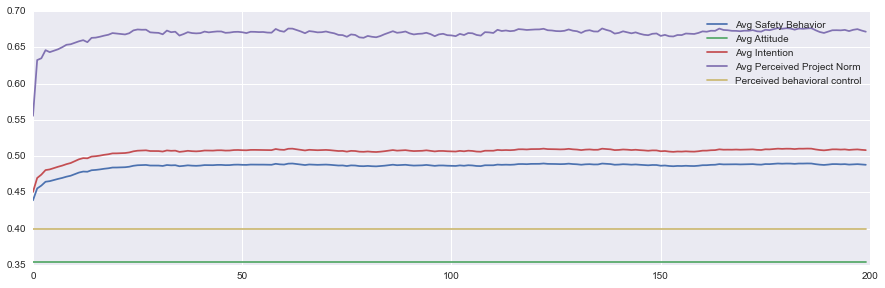

In [399]:
# Plot time series
f = plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(m.history_safety_behavior)
plt.plot(m.history_attitude)
plt.plot(m.history_intention)
plt.plot(m.history_perceived_project_norm)
#plt.plot(m.history_perceived_workgroup_norm)
plt.plot(m.history_percieved_behavioral_control)

plt.legend(("Avg Safety Behavior",
           "Avg Attitude",
           "Avg Intention",
           "Avg Perceived Project Norm",
           "Perceived behavioral control"),
          loc="best")

## Visualizing space


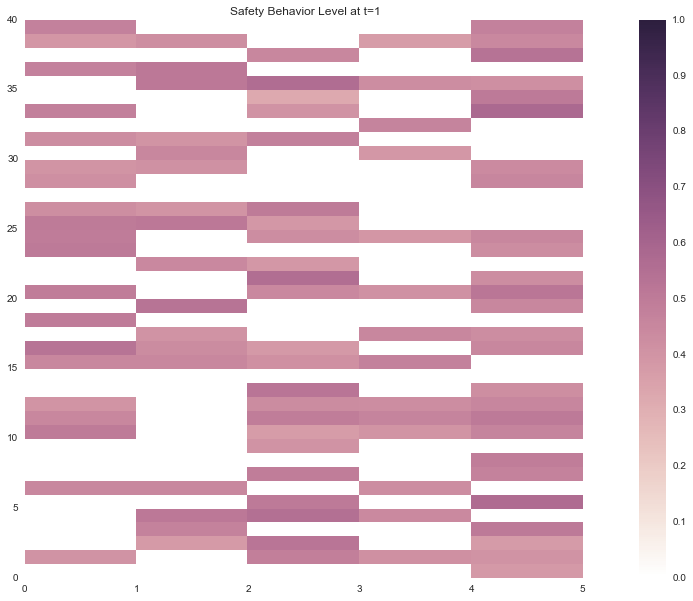

In [395]:
# Get colormap
cmap = seaborn.cubehelix_palette(light=1, as_cmap=True)

def plot_space_safety_behavior(t=None):
    """
    Return a projection of the space that shows the level of worker's safety behavior on each cell.
    """
    f=plt.figure(figsize=(20,10))
    plt.title("Safety Behavior Level at t={0}".format(t))
    plt.pcolor(m.histroy_space_safety_behavior[t], vmin=0.0, vmax=1.0, cmap=cmap)
    ax = f.gca()
    ax.set_aspect(1./ax.get_data_ratio())   
    plt.colorbar()

interact(plot_space_safety_behavior,
                t=IntSlider(min=1, max=m.t-1, step=1))

In [372]:
worker_safety_behavior_history = []
for i in range(len(m.worker)):
    worker_safety_behavior_history.append(m.worker[i].my_safety_behavior_history)


#print worker_safety_behavior_history


worker_safety_behavior_history_df = pandas.DataFrame(worker_safety_behavior_history)

worker_safety_behavior_history_df.head()


worker_safety_behavior_history_df.to_csv("history_for_one_run.csv")


## Setup the Parameter Sweep


In [373]:
## Set number of samples per value and steps per sample

num_samples = 2
num_steps = 50

###1. Sweep over the project based identity and strictness of safety rule

In [374]:
# Set project identity and safety rule strictness values to sweep over
project_identity_sweep_values = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
strictness_safety_rule_sweep_values = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

pi_sr_sweep_output = []

# Iterate over the project identity
for project_identity_value in project_identity_sweep_values:
    
    # Iterate over the safety rule strictness
    for strictness_safety_rule_value in strictness_safety_rule_sweep_values:
        print ("Running {0} samples for project identity value {1}, strictness of safety rule value {2}"\
                  .format(num_samples, project_identity_value, strictness_safety_rule_value))
        
        for n in xrange(num_samples):
            # Input info
            m = Model(min_project_identity = project_identity_value, max_project_identity=project_identity_value, strictness_safety_rule = strictness_safety_rule_value)                          
            
            for t in xrange(num_steps):
                m.step()
            pi_sr_sweep_output.append((project_identity_value,strictness_safety_rule_value, m.get_avg_safety_behavior(), m.get_avg_safety_attitude(), m.get_avg_perceived_workgroup_norm(), m.get_avg_perceived_project_norm()))
            

Running 2 samples for project identity value 0.3, strictness of safety rule value 0.3
Running 2 samples for project identity value 0.3, strictness of safety rule value 0.35
Running 2 samples for project identity value 0.3, strictness of safety rule value 0.4
Running 2 samples for project identity value 0.3, strictness of safety rule value 0.45
Running 2 samples for project identity value 0.3, strictness of safety rule value 0.5
Running 2 samples for project identity value 0.3, strictness of safety rule value 0.55
Running 2 samples for project identity value 0.3, strictness of safety rule value 0.6
Running 2 samples for project identity value 0.3, strictness of safety rule value 0.65
Running 2 samples for project identity value 0.3, strictness of safety rule value 0.7
Running 2 samples for project identity value 0.3, strictness of safety rule value 0.75
Running 2 samples for project identity value 0.3, strictness of safety rule value 0.8
Running 2 samples for project identity value 0.3,

In [375]:
# Set up the pandas DataFrame
pi_sr_sweep_df = pandas.DataFrame(pi_sr_sweep_output,
                columns = ["Pro_Identity", "Strictness", "Avg_Behavior", "Avg_Attitude", "Avg_Crew_Norm", "Avg_Proj_Norm"])

pi_sr_sweep_df.head()

,Pro_Identity,Strictness,Avg_Behavior,Avg_Attitude,Avg_Crew_Norm,Avg_Proj_Norm
0,0.3,0.30,0.366927,0.355962,0.366757,0.327792
1,0.3,0.30,0.365714,0.348202,0.365520,0.325409
2,0.3,0.35,0.364305,0.338305,0.363760,0.356375
3,0.3,0.35,0.377565,0.342050,0.378298,0.360445
4,0.3,0.40,0.384227,0.365981,0.384423,0.393177


In [376]:
# Gte 2D grid Means
pi_sr_sweep_means = pandas.DataFrame(pi_sr_sweep_df.groupby(["Pro_Identity","Strictness"])["Avg_Behavior"].mean())
pi_sr_sweep_surface = pi_sr_sweep_means.reset_index().pivot(index = "Pro_Identity", columns = "Strictness", values="Avg_Behavior")
pi_sr_sweep_surface

Strictness,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
Pro_Identity,,,,,,,,,,,,,,,
0.30,0.366321,0.370935,0.378765,0.388775,0.380981,0.396794,0.391513,0.402253,0.413555,0.414541,0.420074,0.425007,0.429627,0.439784,0.440318
0.35,0.375662,0.366154,0.377896,0.385570,0.389811,0.397279,0.401196,0.413692,0.409775,0.423857,0.428481,0.439699,0.432381,0.442844,0.453782
0.40,0.371660,0.370952,0.388009,0.388824,0.387581,0.396010,0.402202,0.419149,0.419454,0.428526,0.439192,0.438750,0.449813,0.459632,0.455865
0.45,0.368879,0.370657,0.375748,0.388714,0.396888,0.405422,0.414013,0.413164,0.429703,0.440257,0.439837,0.460155,0.461325,0.475515,0.476115
0.50,0.367517,0.367579,0.384179,0.389943,0.394212,0.407922,0.421151,0.428135,0.440467,0.454657,0.460046,0.471653,0.467485,0.487899,0.494940
0.55,0.355879,0.371466,0.367654,0.390924,0.405434,0.413177,0.425741,0.426005,0.449407,0.446713,0.457933,0.474398,0.488507,0.498666,0.500184
0.60,0.357830,0.365288,0.388064,0.401721,0.404481,0.413981,0.430999,0.444480,0.455211,0.464127,0.474751,0.488324,0.501437,0.516102,0.524788
0.65,0.355469,0.372218,0.383491,0.392694,0.406884,0.422740,0.437873,0.448460,0.464119,0.479181,0.482553,0.492092,0.504108,0.528724,0.533663
0.70,0.356930,0.372535,0.375040,0.398438,0.416558,0.425381,0.442005,0.454035,0.461569,0.481518,0.496514,0.507356,0.521393,0.535090,0.547167


In [377]:
pi_sr_sweep_surface.to_csv("pi_sr_sweep_table.csv")

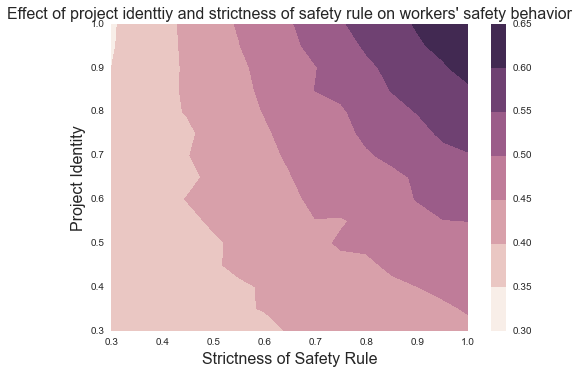

In [378]:
# Plot surface
f = plt.figure()
_ = plt.contourf(pi_sr_sweep_surface.columns, pi_sr_sweep_surface.index, pi_sr_sweep_surface, cmap = seaborn.cubehelix_palette(light=1, as_cmap=True),
                 shade=False)
_ = plt.colorbar()
_ = plt.title("Effect of project identtiy and strictness of safety rule on workers' safety behavior",
              fontsize=16)
_ = plt.xlabel("Strictness of Safety Rule", fontsize=16)
_ = plt.ylabel("Project Identity", fontsize=16)

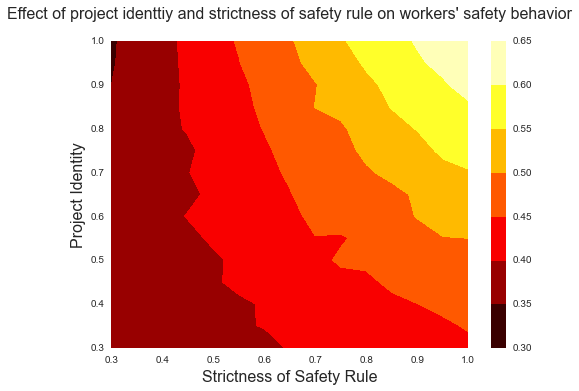

In [379]:
# Plot surface
f = plt.figure()
_ = plt.contourf(pi_sr_sweep_surface.columns, pi_sr_sweep_surface.index, pi_sr_sweep_surface, cmap = 'hot')
_ = plt.colorbar()
_ = plt.title("Effect of project identtiy and strictness of safety rule on workers' safety behavior\n",
              fontsize=16)
_ = plt.xlabel("Strictness of Safety Rule", fontsize=16)
_ = plt.ylabel("Project Identity", fontsize=16)

(0, 15)

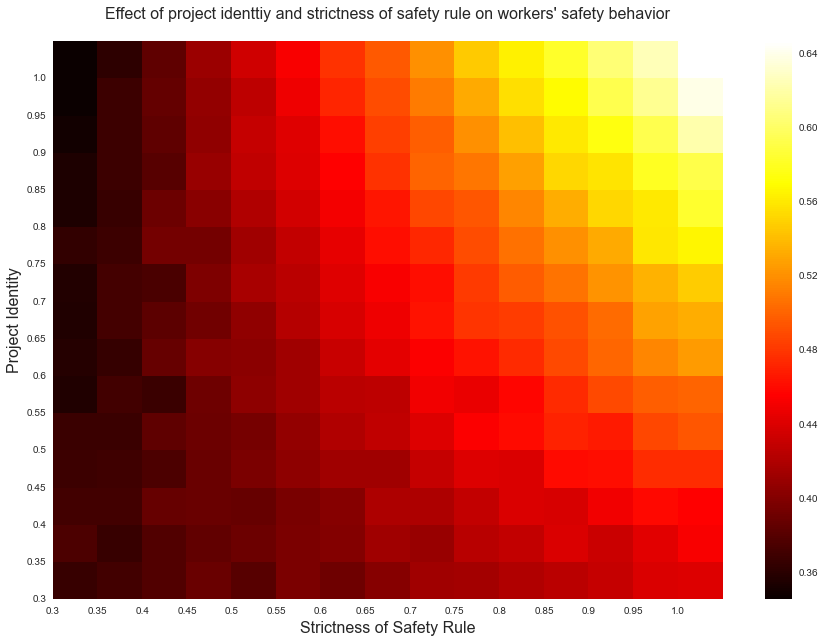

In [388]:
f = plt.figure(figsize=(15,10))
_ = plt.pcolor(pi_sr_sweep_surface, cmap = 'hot')
_ = plt.colorbar()
_ = plt.title("Effect of project identtiy and strictness of safety rule on workers' safety behavior\n",
              fontsize=16)
_ = plt.xlabel("Strictness of Safety Rule", fontsize=16)
_ = plt.ylabel("Project Identity", fontsize=16)
_ = plt.xticks(range(pi_sr_sweep_surface.shape[1]), pi_sr_sweep_surface.columns)
_ = plt.yticks(range(pi_sr_sweep_surface.shape[0]), pi_sr_sweep_surface.index)
plt.xlim((0, pi_sr_sweep_surface.shape[1]))
plt.ylim((0, pi_sr_sweep_surface.shape[0]))

###2. Sweep over the project based identity and frequencey of safety inspection

In [381]:
# Set project identity and safety rule strictness values to sweep over
project_identity_sweep_values = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
num_managers_sweep_values = [10,11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

pi_nm_sweep_output = []

# Iterate over the project identity
for project_identity_value in project_identity_sweep_values:
    
    # Iterate over the safety rule strictness
    for num_managers_value in num_managers_sweep_values:
        print ("Running {0} samples for project identity_ value {1}, number of managers {2}"\
                  .format(num_samples, project_identity_value, num_managers_value))
        
        for n in xrange(num_samples):
            # Input info
            m = Model(num_managers = num_managers_value, min_project_identity = project_identity_value, max_project_identity=project_identity_value)                                                
            for t in xrange(num_steps):
                m.step()
            pi_nm_sweep_output.append((project_identity_value,num_managers_value, m.get_avg_safety_behavior(), m.get_avg_safety_attitude(), m.get_avg_perceived_workgroup_norm(), m.get_avg_perceived_project_norm()))
            

Running 2 samples for project identity_ value 0.3, number of managers 10
Running 2 samples for project identity_ value 0.3, number of managers 11
Running 2 samples for project identity_ value 0.3, number of managers 12
Running 2 samples for project identity_ value 0.3, number of managers 13
Running 2 samples for project identity_ value 0.3, number of managers 14
Running 2 samples for project identity_ value 0.3, number of managers 15
Running 2 samples for project identity_ value 0.3, number of managers 16
Running 2 samples for project identity_ value 0.3, number of managers 17
Running 2 samples for project identity_ value 0.3, number of managers 18
Running 2 samples for project identity_ value 0.3, number of managers 19
Running 2 samples for project identity_ value 0.3, number of managers 20
Running 2 samples for project identity_ value 0.3, number of managers 21
Running 2 samples for project identity_ value 0.3, number of managers 22
Running 2 samples for project identity_ value 0.3, 

In [382]:
# Set up the pandas DataFrame
pi_nm_sweep_df = pandas.DataFrame(pi_nm_sweep_output,
                columns = ["Proj_Identity", "Num_Managers", "Avg_Behavior", "Avg_Attitude", "Avg_Crew_Norm", "Avg_Proj_Norm"])

pi_nm_sweep_df.head()

,Proj_Identity,Num_Managers,Avg_Behavior,Avg_Attitude,Avg_Crew_Norm,Avg_Proj_Norm
0,0.3,10,0.413747,0.349950,0.414212,0.551135
1,0.3,10,0.394742,0.330113,0.394501,0.542689
2,0.3,11,0.405885,0.348588,0.405720,0.560131
3,0.3,11,0.410755,0.343457,0.411358,0.551844
4,0.3,12,0.401899,0.342459,0.402139,0.557366


In [383]:
# Gte 2D grid Means
pi_nm_sweep_means = pandas.DataFrame(pi_nm_sweep_df.groupby(["Proj_Identity","Num_Managers"])["Avg_Behavior"].mean())
pi_nm_sweep_surface = pi_nm_sweep_means.reset_index().pivot(index = "Proj_Identity", columns = "Num_Managers", values="Avg_Behavior")
pi_nm_sweep_surface

Num_Managers,10,11,12,13,14,15,16,17,18,19,...,21,22,23,24,25,26,27,28,29,30
Proj_Identity,,,,,,,,,,,,,,,,,,,,,
0.30,0.404245,0.408320,0.413066,0.411370,0.407673,0.414608,0.405154,0.422081,0.415273,0.418159,...,0.416500,0.417485,0.414829,0.415483,0.425282,0.428481,0.420325,0.419866,0.434410,0.426150
0.35,0.411293,0.410387,0.416085,0.410058,0.414201,0.408051,0.413724,0.420412,0.423942,0.431078,...,0.418065,0.429577,0.429301,0.433843,0.437683,0.428628,0.434216,0.434311,0.427988,0.434676
0.40,0.426321,0.413557,0.429398,0.429662,0.422304,0.419217,0.419388,0.428510,0.440346,0.432150,...,0.429208,0.438871,0.438352,0.436043,0.441758,0.443736,0.436186,0.440793,0.443085,0.439043
0.45,0.423021,0.420893,0.430923,0.427071,0.432367,0.430897,0.432520,0.443273,0.441252,0.438648,...,0.442729,0.443921,0.440501,0.449653,0.439313,0.440259,0.436843,0.455827,0.443410,0.441703
0.50,0.424364,0.432913,0.432082,0.450330,0.440773,0.446787,0.445629,0.454322,0.448546,0.448429,...,0.451563,0.448863,0.460795,0.451452,0.458006,0.457117,0.465841,0.455037,0.454014,0.450626
0.55,0.430562,0.435996,0.441072,0.447817,0.448574,0.439516,0.451347,0.457755,0.455102,0.458607,...,0.458115,0.466256,0.466093,0.460403,0.473364,0.469363,0.473043,0.472519,0.467960,0.469043
0.60,0.435563,0.439564,0.445239,0.453656,0.453950,0.452577,0.459105,0.461294,0.466314,0.460653,...,0.470115,0.469299,0.472886,0.475205,0.470722,0.475048,0.476566,0.479129,0.482653,0.485419
0.65,0.445581,0.448854,0.460346,0.466120,0.452863,0.466436,0.471272,0.477406,0.477810,0.480511,...,0.478671,0.480223,0.480354,0.489194,0.484669,0.479377,0.492154,0.487418,0.492385,0.496317
0.70,0.461301,0.457859,0.474655,0.465445,0.473482,0.474828,0.477863,0.481994,0.488204,0.484445,...,0.485734,0.484992,0.488019,0.496483,0.498747,0.501963,0.500247,0.500503,0.507682,0.504231


In [384]:
pi_nm_sweep_surface.to_csv("pi_nm_sweep_table.csv")

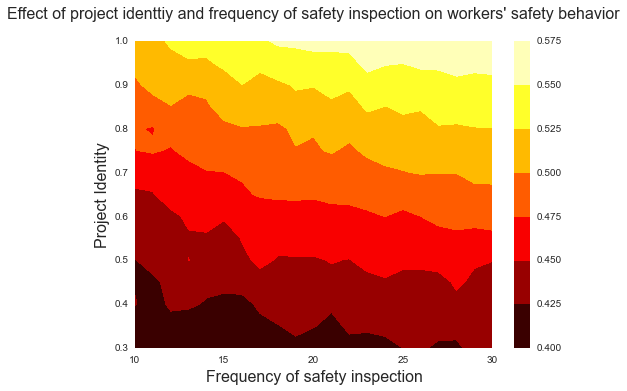

In [386]:
# Plot surface
f = plt.figure()
_ = plt.contourf(pi_nm_sweep_surface.columns, pi_nm_sweep_surface.index, pi_nm_sweep_surface, cmap = 'hot')
_ = plt.colorbar()
_ = plt.title("Effect of project identtiy and frequency of safety inspection on workers' safety behavior\n",
              fontsize=16)
_ = plt.xlabel("Frequency of safety inspection", fontsize=16)
_ = plt.ylabel("Project Identity", fontsize=16)

###3. Sweep over the crew based identity and strictness of safety rule

In [23]:
# Set crew identity and safety rule strictness values to sweep over
crew_identity_sweep_values = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
strictness_safety_rule_sweep_values = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

ci_sr_sweep_output = []

# Iterate over the project identity
for crew_identity_value in crew_identity_sweep_values:
    
    # Iterate over the safety rule strictness
    for strictness_safety_rule_value in strictness_safety_rule_sweep_values:
        print ("Running {0} samples for crew identity value {1}, strictness of safety rule value {2}"\
                  .format(num_samples, crew_identity_value, strictness_safety_rule_value))
        
        for n in xrange(num_samples):
            # Input info
            m = Model(grid_size_for_crew = 5, overlaps_between_crew_grid =1,num_crews = 10,
                num_workers = 10,num_managers = 20, min_project_identity = 0.5, max_project_identity=0.9,
                min_crew_identity = crew_identity_value, max_crew_identity = crew_identity_value, min_attitude = 0.2, max_attitude = 0.5,
                min_perceived_behavioral_control = 0.2,max_perceived_behavioral_control = 0.4, strictness_safety_rule = strictness_safety_rule_value,
                weight_attitude = 0.7, weight_intention = 0.85, norm_compliance = 0.45, internalization = 0.02, memory_capa = 50)                          
            for t in xrange(num_steps):
                m.step()
            ci_sr_sweep_output.append((crew_identity_value,strictness_safety_rule_value, m.get_avg_safety_behavior(), m.get_avg_safety_attitude(), m.get_avg_perceived_workgroup_norm(), m.get_avg_perceived_project_norm()))
            

Running 2 samples for crew identity value 0.3, strictness of safety rule value 0.3
Running 2 samples for crew identity value 0.3, strictness of safety rule value 0.4
Running 2 samples for crew identity value 0.3, strictness of safety rule value 0.5
Running 2 samples for crew identity value 0.3, strictness of safety rule value 0.6
Running 2 samples for crew identity value 0.3, strictness of safety rule value 0.7
Running 2 samples for crew identity value 0.3, strictness of safety rule value 0.8
Running 2 samples for crew identity value 0.3, strictness of safety rule value 0.9
Running 2 samples for crew identity value 0.3, strictness of safety rule value 1.0
Running 2 samples for crew identity value 0.4, strictness of safety rule value 0.3
Running 2 samples for crew identity value 0.4, strictness of safety rule value 0.4
Running 2 samples for crew identity value 0.4, strictness of safety rule value 0.5
Running 2 samples for crew identity value 0.4, strictness of safety rule value 0.6
Runn

In [ ]:
# Set up the pandas DataFrame
ci_sr_sweep_df = pandas.DataFrame(ci_sr_sweep_output,
                columns = ["Crew_Identity", "Strictness", "Avg_Behavior", "Avg_Attitude", "Avg_Crew_Norm", "Avg_Proj_Norm"])
# Gte 2D grid Means
ci_sr_sweep_means = pandas.DataFrame(ci_sr_sweep_df.groupby(["Crew_Identity","Strictness"])["Avg_Behavior"].mean())
ci_sr_sweep_surface = ci_sr_sweep_means.reset_index().pivot(index = "Crew_Identity", columns = "Strictness", values="Avg_Behavior")
ci_sr_sweep_surface


In [ ]:
ci_sr_sweep_surface.to_csv("ci_sr_sweep_table.csv")

In [ ]:
# Plot surface
f = plt.figure()
_ = plt.contourf(ci_sr_sweep_surface.columns, ci_sr_sweep_surface.index, ci_sr_sweep_surface, vmin=0.24, vmax=0.72, cmap = 'hot')
_ = plt.colorbar()
_ = plt.title("Effect of crew identtiy and strictness of safety rule on workers' safety behavior\n",
              fontsize=16)
_ = plt.xlabel("Strictness of Safety Rule", fontsize=16)
_ = plt.ylabel("Crew Identity", fontsize=16)